In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn
from keras import models, ops
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn import svm, linear_model



# Options: "covid_cxr" or "syntetic"
dataset_name = "syntetic"
epochs = 100
batch = 1024
tsne_components = 2

In [2]:
root = '../..'
dataset_path = f"{root}/datasets/{dataset_name}_embeddings.npz"
predictions_path = f"{root}/datasets/{dataset_name}_predictions.npz"
siamese_save_path = f"{root}/models/{dataset_name}_siamese.keras"
classifier_path = f"{root}/models/{dataset_name}_classifier.keras"

## MODELS
def distance(vects):
    """
    Computes the cosine distance between pairs of vectors.
    """
    x, y = vects[:,0], vects[:,1]
    x = ops.normalize(x, axis=1)
    y = ops.normalize(y, axis=1)
    return ops.sum(x * y, axis=1)

@keras.saving.register_keras_serializable()
def contrastive_Sig_loss(y_true, y_pred):
    z = (0.5 - y_true) * 2  # z = 1 per D+, z = -1 per D-
    dist = distance(y_pred)

    similarity = ops.negative(1.0 * dist) + 0.0
    denomiator = 1 + ops.exp(z * similarity)
    batch_loss = ops.log(1 / denomiator)
    return ops.negative(ops.mean(batch_loss))

classifier = models.load_model(classifier_path)
best_siamese = models.load_model(siamese_save_path)
correction = best_siamese.get_layer('correction')

In [3]:
## DATASET
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

## DATASET PREDICTIONS
y_train_pred = classifier.predict(x_train, verbose=0)
y_val_pred = classifier.predict(x_val, verbose=0)
y_test_pred = classifier.predict(x_test, verbose=0)

## DATASET MODIFICATION
x_train_modified = correction(x_train)
x_val_modified = correction(x_val)
x_test_modified = correction(x_test)

## BALANCE CLASSES
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)
total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}


In [4]:
## DATASET REDUCTION WITH TSNE
tsne = TSNE(n_components=tsne_components)
x_train_tsne = tsne.fit_transform(x_train)
print("TSNE on training set done")
x_val_tsne = tsne.fit_transform(x_val)
print("TSNE on validation set done")
x_test_tsne = tsne.fit_transform(x_test)
print("TSNE on test set done")
x_train_modified_tsne = tsne.fit_transform(x_train_modified)
print("TSNE on modified training set done")
x_val_modified_tsne = tsne.fit_transform(x_val_modified)
print("TSNE on modified validation set done")
x_test_modified_tsne = tsne.fit_transform(x_test_modified)
print("TSNE on modified test set done")

TSNE on training set done
TSNE on validation set done
TSNE on test set done
TSNE on modified training set done
TSNE on modified validation set done
TSNE on modified test set done


In [5]:
all_datasets = {
    'original': (x_train, x_val, x_test),
    'modified': (x_train_modified, x_val_modified, x_test_modified),
    'tsne_original': (x_train_tsne, x_val_tsne, x_test_tsne),
    'tsne_modified': (x_train_modified_tsne, x_val_modified_tsne, x_test_modified_tsne),
    'y': (y_train, y_val, y_test),
}

In [6]:
## EVALUATION ALL THE CLASSIFIERS
class ModelToEvaluate:
    def __init__(self, name:str, dataset: tuple, model, call_func):
        self.name = name
        self.model = model
        self.call_func = call_func

        self.x_train = dataset[0]
        self.x_val = dataset[1]
        self.x_test = dataset[2]

    def evaluate(self):
        kwargs = {'verbose': 0} if isinstance(self.model, keras.Model) or isinstance(self.model, keras.Sequential) else {}
        self.y_train_pred = self.call_func(self.model.predict(self.x_train, **kwargs))
        self.y_val_pred = self.call_func(self.model.predict(self.x_val, **kwargs))
        self.y_test_pred = self.call_func(self.model.predict(self.x_test, **kwargs))

    def fit(self):
        print(f"Training {self.name} model...")
        if isinstance(self.model, keras.Model) or isinstance(self.model, keras.Sequential):
            kwargs = {
                'validation_data': (self.x_val, y_val),
                'verbose': 0,
                'epochs': epochs,
                'batch_size': batch,
                'class_weight': class_weights,
                'callbacks': [keras.callbacks.EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True)]
            }
            self.model.fit(self.x_train, y_train, **kwargs)
        elif isinstance(self.model, sklearn.base.BaseEstimator):
            self.model.fit(self.x_train, y_train)
        else:
            raise ValueError("Model type not supported for training.")

    def print_results(self):
        titles_data = ["Training", "Validation", "Test"]
        true_labels = all_datasets['y']
        prediction = [self.y_train_pred, self.y_val_pred, self.y_test_pred]

        list_data = zip(titles_data, true_labels, prediction)
        _, axes = plt.subplots(1, len(titles_data), figsize=None)

        for i, (title_data, yy_true, yy_pred) in enumerate(list_data):
            ConfusionMatrixDisplay.from_predictions(
                yy_true, yy_pred,
                normalize='true',
                display_labels=[i for i in range(total_classes)],
                cmap=plt.cm.Blues,
                colorbar=False,
                ax=axes[i]
            )
            axes[i].set_title(f"{self.name} {title_data}\n"
                                + f"Accuracy: {balanced_accuracy_score(yy_true, yy_pred):.2%}\n"
                                + f"F1-Score: {f1_score(yy_true, yy_pred):.2f}")
        plt.tight_layout()
        plt.show()

In [9]:
classifier_mlp = keras.models.Sequential()
classifier_mlp.add(keras.layers.InputLayer(shape=(x_train_modified_tsne.shape[1],)))
classifier_mlp.add(keras.layers.Dense(8))
classifier_mlp.add(keras.layers.LeakyReLU())
classifier_mlp.add(keras.layers.Dense(total_classes, activation='softmax'))
classifier_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

models = [
    ModelToEvaluate("Cls-Mod", all_datasets['modified'], keras.models.clone_model(classifier), lambda preds: ops.argmax(preds, axis=1)),
    ModelToEvaluate("MLP t-SNE", all_datasets['tsne_original'], keras.models.clone_model(classifier_mlp), lambda preds: ops.argmax(preds, axis=1)),
    ModelToEvaluate("MLP-Mod t-SNE", all_datasets['tsne_modified'], keras.models.clone_model(classifier_mlp), lambda preds: ops.argmax(preds, axis=1)),
    ModelToEvaluate("LR t-SNE", all_datasets['tsne_original'], linear_model.LogisticRegression(), lambda preds: np.round(preds).astype(int)),
    ModelToEvaluate("LR-Mod t-SNE", all_datasets['tsne_modified'], linear_model.LogisticRegression(), lambda preds: np.round(preds).astype(int)),
    ModelToEvaluate("SVM t-SNE", all_datasets['tsne_original'], svm.LinearSVC(), lambda preds: preds),
    ModelToEvaluate("SVM-Mod t-SNE", all_datasets['tsne_modified'], svm.LinearSVC(), lambda preds: preds)
]

for m in models:
    m.fit()
    m.evaluate()

original = ModelToEvaluate("Cls", all_datasets['original'], keras.models.clone_model(classifier), lambda preds: ops.argmax(preds, axis=1))
original.y_train_pred = y_train_pred.argmax(axis=1)
original.y_val_pred = y_val_pred.argmax(axis=1)
original.y_test_pred = y_test_pred.argmax(axis=1)

models = [original, *models]

Training Cls-Mod model...
Training MLP t-SNE model...
Training MLP-Mod t-SNE model...
Training LR t-SNE model...
Training LR-Mod t-SNE model...
Training SVM t-SNE model...
Training SVM-Mod t-SNE model...


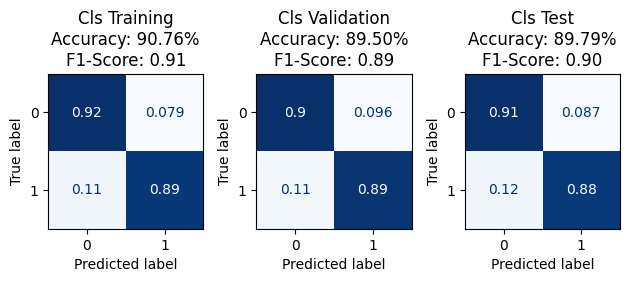

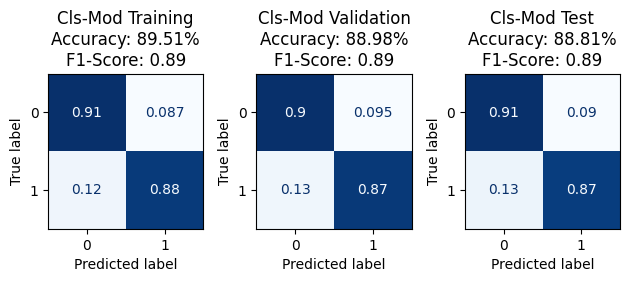

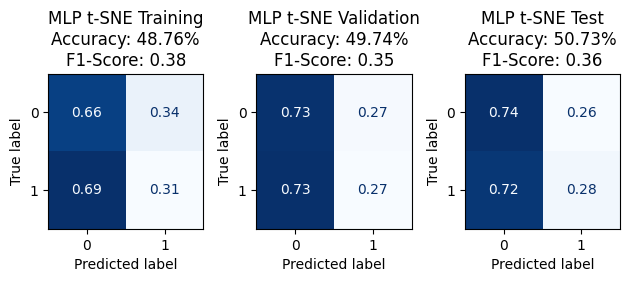

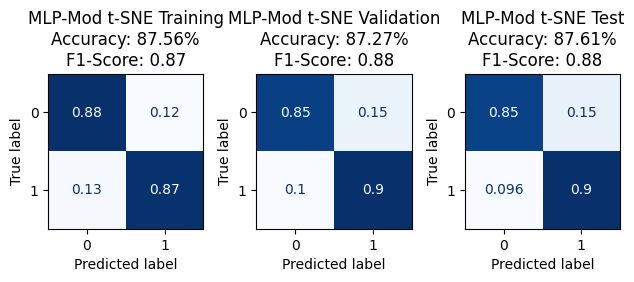

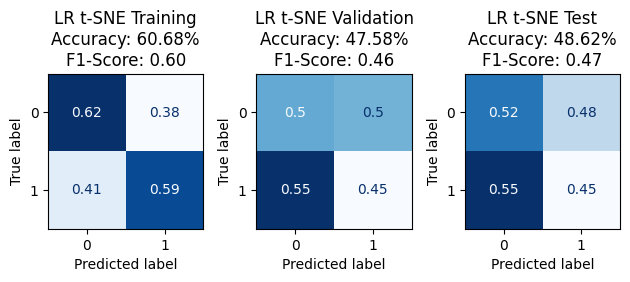

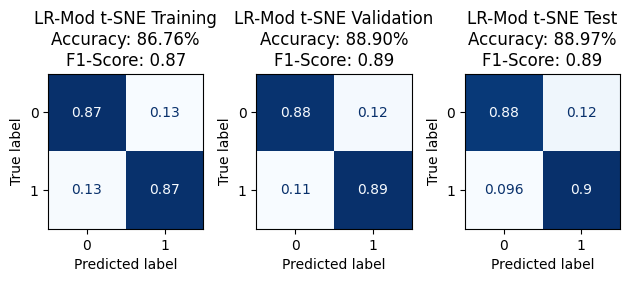

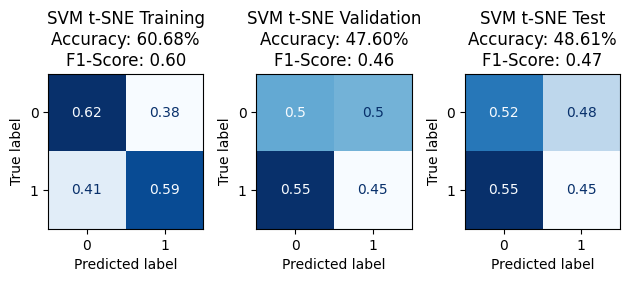

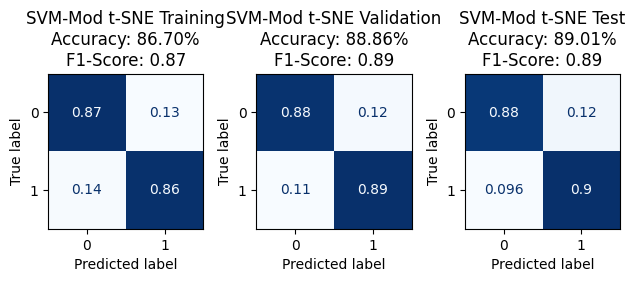

In [10]:
for m in models:
    m.print_results()

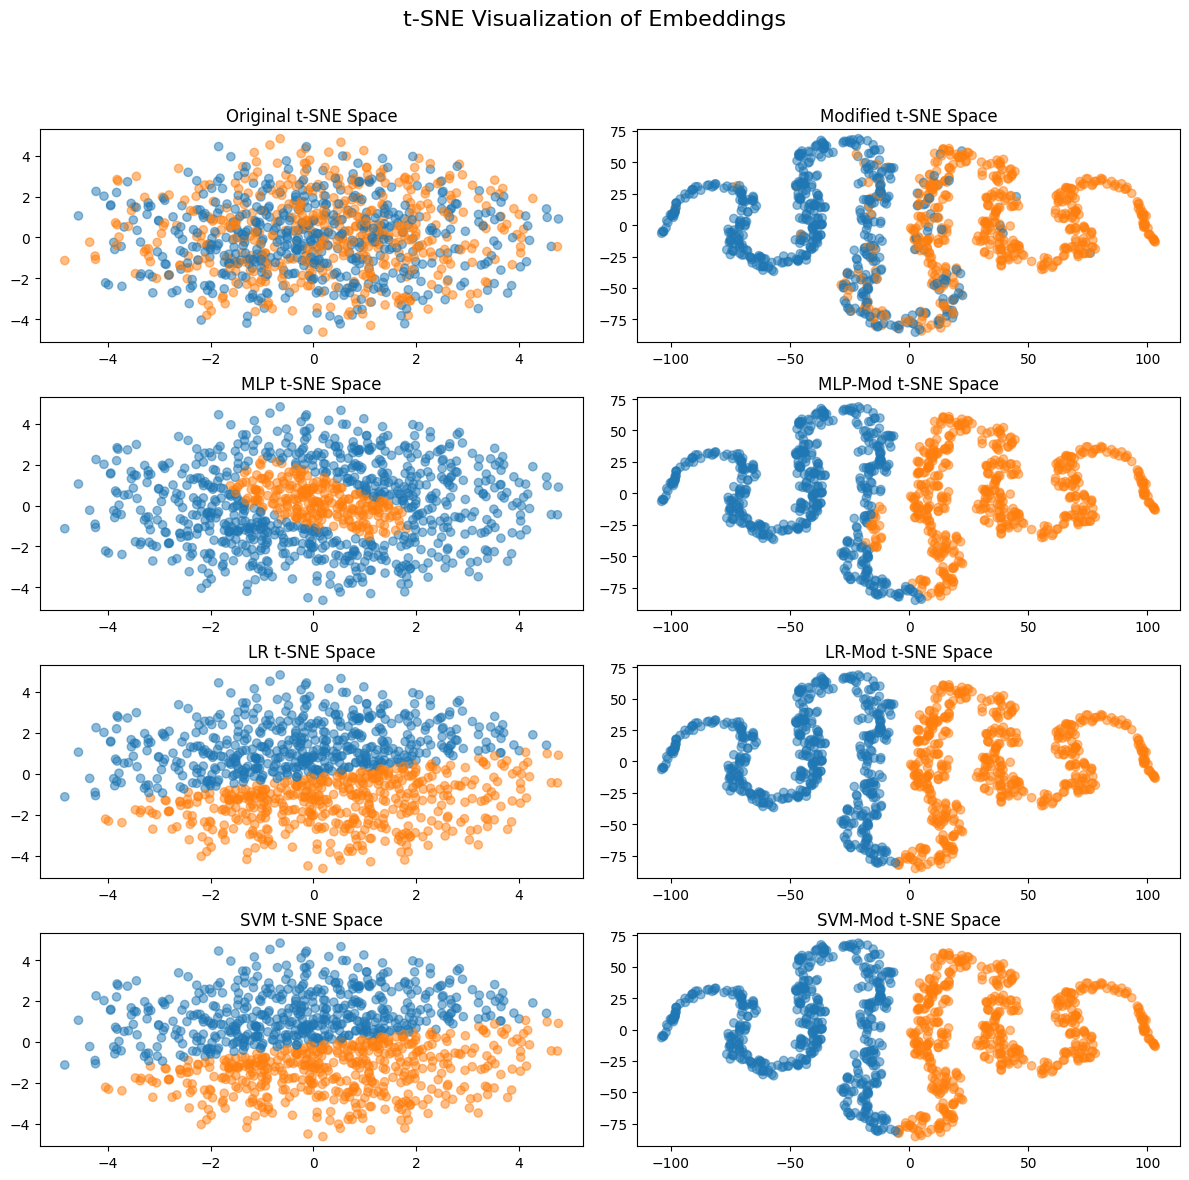

In [11]:
# Plot the t-SNE embeddings
sample_size = 1000
indices = np.random.choice(len(y_test), size=min(sample_size, len(y_test)), replace=False)
colors = list(plt.cm.tab10.colors[:total_classes])

m_orig = ModelToEvaluate("Original t-SNE", all_datasets['tsne_original'], None, None)
m_orig.y_test_pred = y_test
m_mod = ModelToEvaluate("Modified t-SNE", all_datasets['tsne_modified'], None, None)
m_mod.y_test_pred = y_test

models_to_print = [m_orig, m_mod, *[m for m in models if m.x_train.shape[1] == 2]]
subplots = len(models_to_print)

plt.figure(figsize=(12, 3*(subplots // 2)))

for i, model in enumerate(models_to_print):
    h = model.x_test[indices]
    c = [colors[i] for i in model.y_test_pred[indices]]
    title = f"{model.name} Space"

    plt.subplot(subplots // 2, 2, i + 1)
    plt.scatter(h[:,0], h[:,1], alpha=0.5, c=c)
    plt.title(title)

plt.tight_layout()
plt.suptitle('t-SNE Visualization of Embeddings', fontsize=16)
plt.subplots_adjust(top=0.88)  # Adjust the top to make room for the title
plt.show()